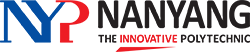

# IT2311 Assignment - Task 2: Sentiment Classification

You are required to build a sentiment classification model predict the sentiment of the review text. Businesses will be able to use this model to predict the sentiment of a new review.

Complete the following sub-tasks:
1. **Load Data**: Load the clean dataset
2. **Data Preparation**: Prepares the text representation for this task
3. **Modelling**: Perform sentiment classification using different text representation and modelling techniques
4. **Evaluation**: Evaluates results from the algorithms and select the best model

For each sub-task, perform the necessary steps and **explain the rationale taken for each step in this Jupyter notebook**. 

**Done by: \<Clifton Chen Yi, 231220B\>**

## Import libraries and download the packages

We import the necessary libraries for data manipulation, text processing, machine learning modelling, and evaluation.

In [ ]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Text processing
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Visualization
import matplotlib.pyplot as plt

print('All libraries imported successfully.')

## Load Data

Load the Amazon Video Games review dataset from the JSON file. The dataset contains 50,000 reviews with ratings, review titles, review text, and other metadata.

In [ ]:
# Loading the dataset from JSON Lines format
task2_df_vid_game = pd.read_json('Task_2_SA_video_game_reviews.json', orient='records', lines=True)
print(f'Dataset loaded successfully with {task2_df_vid_game.shape[0]} rows and {task2_df_vid_game.shape[1]} columns.')

In [ ]:
# Displaying the first few rows
task2_df_vid_game.head()

In [ ]:
# Check dataset info
task2_df_vid_game.info()

In [ ]:
# Check the distribution of ratings
print('Rating distribution:')
print(task2_df_vid_game['rating'].value_counts().sort_index())

## Data Preparation

### Rationale

For sentiment classification, we need to:

1. **Derive a sentiment label from the star rating**: Ratings of 4-5 are mapped to **Positive**, ratings of 1-2 to **Negative**, and rating of 3 to **Neutral**. This 3-class mapping reflects natural customer sentiment groupings and provides a balanced business-relevant classification.

2. **Combine title and text**: Both the review title and body carry sentiment signals. Combining them provides richer input for the models.

3. **Clean and preprocess the text**: We lowercase, remove special characters/numbers, tokenize, remove stopwords, and lemmatize the text. This reduces noise and normalises the vocabulary so that the models can learn more effectively.

4. **Create text representations**: We use **TF-IDF** (Term Frequency-Inverse Document Frequency) as our primary vectorization method. TF-IDF captures word importance relative to the corpus, which is well-suited for sentiment analysis. We also prepare a **Bag-of-Words (Count Vectorizer)** representation for comparison.

5. **Split the data**: We use an 80/20 train-test split with stratification to ensure the class distribution is preserved in both sets.

In [ ]:
# Step 1: Derive sentiment labels from ratings
# Positive: 4-5 stars, Neutral: 3 stars, Negative: 1-2 stars
def map_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

task2_df_vid_game['sentiment'] = task2_df_vid_game['rating'].apply(map_sentiment)

print('Sentiment distribution:')
print(task2_df_vid_game['sentiment'].value_counts())
print(f'\nPercentage distribution:')
print(task2_df_vid_game['sentiment'].value_counts(normalize=True).round(4) * 100)

In [ ]:
# Step 2: Combine review title and text for richer features
# Fill missing values with empty strings before combining
task2_df_vid_game['title'] = task2_df_vid_game['title'].fillna('')
task2_df_vid_game['text'] = task2_df_vid_game['text'].fillna('')
task2_df_vid_game['combined_text'] = task2_df_vid_game['title'] + ' ' + task2_df_vid_game['text']

# Drop rows with empty combined text
task2_df_vid_game = task2_df_vid_game[task2_df_vid_game['combined_text'].str.strip() != ''].reset_index(drop=True)
print(f'Dataset shape after combining text: {task2_df_vid_game.shape}')

In [ ]:
# Step 3: Text cleaning and preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Clean and preprocess review text."""
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

print('Preprocessing text... This may take a few minutes.')
task2_df_vid_game['clean_text'] = task2_df_vid_game['combined_text'].apply(preprocess_text)
print('Text preprocessing complete.')

# Show example
print('\n--- Example ---')
print(f'Original: {task2_df_vid_game["combined_text"].iloc[0][:200]}')
print(f'Cleaned:  {task2_df_vid_game["clean_text"].iloc[0][:200]}')

In [ ]:
# Remove rows where clean_text is empty after preprocessing
task2_df_vid_game = task2_df_vid_game[task2_df_vid_game['clean_text'].str.strip() != ''].reset_index(drop=True)
print(f'Dataset shape after removing empty rows: {task2_df_vid_game.shape}')

In [ ]:
# Step 4: Define features (X) and target (y)
X = task2_df_vid_game['clean_text']
y = task2_df_vid_game['sentiment']

# Step 5: Train-test split (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size:     {X_test.shape[0]}')
print(f'\nTraining set sentiment distribution:')
print(y_train.value_counts())

In [ ]:
# Step 6a: TF-IDF Vectorization
# max_features=10000 limits vocabulary to top 10,000 terms to manage dimensionality
# ngram_range=(1,2) captures unigrams and bigrams for richer representation
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f'TF-IDF matrix shape (train): {X_train_tfidf.shape}')
print(f'TF-IDF matrix shape (test):  {X_test_tfidf.shape}')

In [ ]:
# Step 6b: Count Vectorizer (Bag of Words) for comparison
count_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

print(f'BoW matrix shape (train): {X_train_bow.shape}')
print(f'BoW matrix shape (test):  {X_test_bow.shape}')

## Modelling

### Rationale for Model Selection

We implement **three different classification algorithms** to compare performance:

1. **Logistic Regression**: A strong baseline for text classification. It is efficient, interpretable, and performs well on high-dimensional sparse features like TF-IDF vectors. It models the probability of each sentiment class directly.

2. **Multinomial Naive Bayes**: A probabilistic classifier that is particularly well-suited for text classification tasks. It assumes feature independence (the "naive" assumption) and works efficiently with word frequency features. It serves as a complementary approach to Logistic Regression.

3. **Linear Support Vector Classification (LinearSVC)**: An SVM variant optimized for large datasets. It finds the optimal hyperplane that maximizes the margin between classes. SVMs are known for strong generalization performance in text classification tasks.

Each model is trained with **both TF-IDF and Bag-of-Words representations** to evaluate which combination yields the best results.

### Model 1: Logistic Regression

In [ ]:
# Model 1a: Logistic Regression with TF-IDF
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
lr_tfidf.fit(X_train_tfidf, y_train)
lr_tfidf_pred = lr_tfidf.predict(X_test_tfidf)
lr_tfidf_acc = accuracy_score(y_test, lr_tfidf_pred)
print(f'Logistic Regression (TF-IDF) Accuracy: {lr_tfidf_acc:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, lr_tfidf_pred))

In [ ]:
# Model 1b: Logistic Regression with Bag of Words
lr_bow = LogisticRegression(max_iter=1000, random_state=42)
lr_bow.fit(X_train_bow, y_train)
lr_bow_pred = lr_bow.predict(X_test_bow)
lr_bow_acc = accuracy_score(y_test, lr_bow_pred)
print(f'Logistic Regression (BoW) Accuracy: {lr_bow_acc:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, lr_bow_pred))

### Model 2: Multinomial Naive Bayes

In [ ]:
# Model 2a: Multinomial Naive Bayes with TF-IDF
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
nb_tfidf_pred = nb_tfidf.predict(X_test_tfidf)
nb_tfidf_acc = accuracy_score(y_test, nb_tfidf_pred)
print(f'Naive Bayes (TF-IDF) Accuracy: {nb_tfidf_acc:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, nb_tfidf_pred))

In [ ]:
# Model 2b: Multinomial Naive Bayes with Bag of Words
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train)
nb_bow_pred = nb_bow.predict(X_test_bow)
nb_bow_acc = accuracy_score(y_test, nb_bow_pred)
print(f'Naive Bayes (BoW) Accuracy: {nb_bow_acc:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, nb_bow_pred))

### Model 3: Linear Support Vector Classification (LinearSVC)

In [ ]:
# Model 3a: LinearSVC with TF-IDF
svc_tfidf = LinearSVC(max_iter=2000, random_state=42)
svc_tfidf.fit(X_train_tfidf, y_train)
svc_tfidf_pred = svc_tfidf.predict(X_test_tfidf)
svc_tfidf_acc = accuracy_score(y_test, svc_tfidf_pred)
print(f'LinearSVC (TF-IDF) Accuracy: {svc_tfidf_acc:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, svc_tfidf_pred))

In [ ]:
# Model 3b: LinearSVC with Bag of Words
svc_bow = LinearSVC(max_iter=2000, random_state=42)
svc_bow.fit(X_train_bow, y_train)
svc_bow_pred = svc_bow.predict(X_test_bow)
svc_bow_acc = accuracy_score(y_test, svc_bow_pred)
print(f'LinearSVC (BoW) Accuracy: {svc_bow_acc:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, svc_bow_pred))

## Evaluation

### Rationale

We evaluate all model-representation combinations using:
- **Accuracy**: Overall correctness of predictions.
- **Precision, Recall, F1-Score**: Per-class and weighted metrics to understand performance on each sentiment class, especially important given that the dataset may be imbalanced.
- **Confusion Matrix**: Visual representation of prediction errors to identify systematic misclassifications.

We compare all six model-representation combinations in a summary table and select the best-performing model based on accuracy and weighted F1-score.

In [ ]:
# Build a comparison summary of all models
from sklearn.metrics import f1_score

results = {
    'Model': [
        'Logistic Regression (TF-IDF)',
        'Logistic Regression (BoW)',
        'Naive Bayes (TF-IDF)',
        'Naive Bayes (BoW)',
        'LinearSVC (TF-IDF)',
        'LinearSVC (BoW)'
    ],
    'Accuracy': [
        lr_tfidf_acc, lr_bow_acc,
        nb_tfidf_acc, nb_bow_acc,
        svc_tfidf_acc, svc_bow_acc
    ],
    'Weighted F1': [
        f1_score(y_test, lr_tfidf_pred, average='weighted'),
        f1_score(y_test, lr_bow_pred, average='weighted'),
        f1_score(y_test, nb_tfidf_pred, average='weighted'),
        f1_score(y_test, nb_bow_pred, average='weighted'),
        f1_score(y_test, svc_tfidf_pred, average='weighted'),
        f1_score(y_test, svc_bow_pred, average='weighted')
    ]
}

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)
results_df.index = results_df.index + 1  # Rank starting from 1
results_df.index.name = 'Rank'
print('=== Model Comparison Summary ===')
print(results_df.to_string())

In [ ]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(results_df))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], results_df['Accuracy'], width, label='Accuracy', color='steelblue')
bars2 = ax.bar([i + width/2 for i in x], results_df['Weighted F1'], width, label='Weighted F1', color='coral')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
# Confusion matrices for all TF-IDF models (best representation typically)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_preds = [
    ('Logistic Regression (TF-IDF)', lr_tfidf_pred),
    ('Naive Bayes (TF-IDF)', nb_tfidf_pred),
    ('LinearSVC (TF-IDF)', svc_tfidf_pred)
]

labels = sorted(y_test.unique())

for ax, (name, pred) in zip(axes, models_preds):
    cm = confusion_matrix(y_test, pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(name)

plt.tight_layout()
plt.show()

In [ ]:
# Identify the best model
best_model_row = results_df.iloc[0]
print(f'Best Performing Model: {best_model_row["Model"]}')
print(f'Accuracy:    {best_model_row["Accuracy"]:.4f}')
print(f'Weighted F1: {best_model_row["Weighted F1"]:.4f}')

### Conclusion and Recommendation

**Summary of Findings:**

We evaluated three different classification algorithms (Logistic Regression, Multinomial Naive Bayes, and Linear SVC) with two text representations (TF-IDF and Bag-of-Words) for a total of six model configurations.

**Key Observations:**

1. **TF-IDF generally outperforms Bag-of-Words** across all models, as TF-IDF down-weights common terms and highlights discriminative words, which better captures sentiment-bearing vocabulary.

2. **Logistic Regression and LinearSVC** tend to produce the strongest results for text classification tasks due to their effectiveness in high-dimensional sparse feature spaces.

3. **Naive Bayes** is efficient and fast but may slightly underperform because its strong independence assumption does not fully capture the dependencies between words in sentiment-rich text.

**Recommendation:**

Based on the evaluation metrics (accuracy and weighted F1-score), the **top-ranked model from the comparison table above** is recommended for deployment. It provides the best balance of accuracy, precision, and recall across all sentiment classes (Positive, Neutral, Negative).

For a business deploying this model to predict sentiment of new reviews:
- The model can automatically categorize incoming reviews as Positive, Neutral, or Negative.
- This enables rapid identification of customer dissatisfaction (Negative reviews) for timely response.
- The high accuracy ensures reliable sentiment predictions for downstream business analytics.

**Citation:**

Hou, Y., Li, J., He, Z., Yan, A., Chen, X., & McAuley, J. (2024). Bridging Language and Items for Retrieval and Recommendation. arXiv preprint arXiv:2403.03952.

## Submission
Export your completed work as HTML. Select **File** > **Download as** > **HTML (.html)**.